In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
# can try doing addfiles to spark init in nb_spark - maybe terminal option for files
from src import EDA, ModelEvaluation, Preprocess, Split
%load_ext autoreload
%autoreload 2

spark_session = SparkSession.builder.getOrCreate()

In [27]:
def get_random_scores(n, max_score):
    return np.random.random_sample(n, ) * max_score

def create_dataset(df, min_games_played=0, min_users_for_game=0):
    df = EDA.restrict_user_item(df, min_games_played=min_games_played, min_users_for_game=min_users_for_game)
    pandas_train_test = Split.PandasTrainTest(df, seed=1)
    k_fold_dfs = pandas_train_test.get_k_folds(5, game_split_train=.3)
    print('first train test split size: {}, {} '.format(k_fold_dfs[0][0].shape[0], k_fold_dfs[0][1].shape[0]))
    sparkified_k_fold_dfs = [(spark_session.createDataFrame(a), spark_session.createDataFrame(b)) for a, b in k_fold_dfs]
    return sparkified_k_fold_dfs

In [28]:
# we leave more than the top sorted by prediction because the actual may be n away from the 
# top predictions
def sort_predictions_slice(arr, n):
    actual_and_pred = np.array(arr)
    # sort by predictions
    indeces = np.argsort(actual_and_pred[:, 1])
    return actual_and_pred[indeces[::-1]][:n].tolist()

def dcg_at_k(scores, k):
    """
    Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float
    """
    r = np.asfarray(scores)[:k]
    if r.size:
        # item 1 and 2 have same weights
        # return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        # use below for more emphasis on first rank
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    print('sersly?')
    return 0.

def ndcg_at_k(scores, k):
    """
    Normalized Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float from 0 to 1
    """
    dcg_max = dcg_at_k(sorted(scores, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(scores, k) / dcg_max

def get_rdd_ndcg(rdd, top_n=3, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    rdd_ndcg = rdd.map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda total, val: total + val) \
        .map(lambda kv: (kv[0], sort_predictions_slice(kv[1], 1000))) \
        .map(lambda kv: ndcg_at_k(np.array(kv[1])[:, 0], top_n)) \
        .sum()
    return rdd_ndcg

def fit_and_calculate_kfold_ndcg(model, train_test_dfs, top_n=5):
    results = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        predictions_rdd = predictions.rdd
        ndcg = get_rdd_ndcg(predictions_rdd, top_n=top_n, prediction_col='prediction')
        # can divide ndcg by user count - would be more efficient to pass counts
        num_users = len(predictions.groupby('uid').count().collect())
        results.append(ndcg / num_users)
    return sum(results) / len(results)

def fit_and_predict_kfold(model, train_test_dfs):
    prediction_rdds = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        prediction_rdd = predictions.rdd
        prediction_rdds.append(prediction_rdd)
    return prediction_rdds

def get_ndcg_and_random_ndcg(dataset):
    k_fold_prediction_rdds = fit_and_predict_kfold(als_model, dataset)
    ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
    random_ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='random_prediction') for predictions_rdd in k_fold_prediction_rdds]
    ndcg = sum(ndcgs) / len(ndcgs)
    random_ndcg = sum(random_ndcgs) / len(random_ndcgs)
    print('ndcg: ', ndcg)
    print('random_ndcg: ', random_ndcg)
    return (ndcg, random_ndcg)

In [6]:
# need holdout users.  Hold out 10%.  We could put some percent of their games into
# the training but it will make it very complicated
steam_df = EDA.load_200k()
preprocessor = Preprocess.PandasALSPreprocessor(steam_df)
preprocessor.process_general()
preprocessor.process_buckets()
preprocessor.process_min_max()
preprocessor.keep_standard_columns()
steam_df = preprocessor.get_df()
max_score = steam_df['playtime_min_max'].max()
steam_df['random_prediction'] = get_random_scores(steam_df.shape[0], max_score)
pandas_train_test = Split.PandasTrainTest(steam_df, seed=1)
train_val, holdout_test = pandas_train_test.user_only_split(user_split_train=.9)
print('split sizes: ', (train_val.shape[0], holdout_test.shape[0]))
train_val.head(2)

split sizes:  (62791, 7698)


,uid,playtime,playtime_min_max,game_name,game_uid,random_prediction
1,151603712,273.0,0.412256,The Elder Scrolls V Skyrim,0,1.123589
3,151603712,87.0,0.414122,Fallout 4,1,1.489224


In [29]:
als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10
);

In [17]:
base_case = create_dataset(train_val, min_games_played=0, min_users_for_game=0)
get_ndcg_and_random_ndcg(base_case)

Number of users:  10215
first train test split size 53164, 9627: 
ndcg:  431.024559748
random_ndcg:  365.709611512


(431.02455974834868, 365.70961151170661)

## Cold Start for Users

In [ ]:
min_games_played_datasets1 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0) for i in range(1,10)]

In [20]:
# prediction vs random_prediction ndcg
user_results1 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_games_played_datasets1]
user_increase1 = [((predicted / random) - 1) * 100 for predicted, random in user_results1]

ndcg:  431.024559748
random_ndcg:  365.709611512
ndcg:  426.150640534
random_ndcg:  363.214365998
ndcg:  427.690077312
random_ndcg:  362.533219841
ndcg:  325.154006477
random_ndcg:  263.271049074
ndcg:  263.827389752
random_ndcg:  210.020082089
ndcg:  219.223411865
random_ndcg:  168.768726783
ndcg:  186.867872024
random_ndcg:  138.781498671
ndcg:  163.929897318
random_ndcg:  121.201318144
ndcg:  147.792840053
random_ndcg:  104.767347795


In [23]:
min_games_played_datasets2 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0) for i in range(10,20)]

Number of users:  1339
first train test split size 38833, 6926: 
Number of users:  1243
first train test split size 38194, 6564: 
Number of users:  1155
first train test split size 37895, 5936: 
Number of users:  1094
first train test split size 37177, 5922: 
Number of users:  1017
first train test split size 36543, 5431: 
Number of users:  962
first train test split size 35763, 5520: 
Number of users:  889
first train test split size 34761, 5472: 
Number of users:  838
first train test split size 33951, 5352: 
Number of users:  789
first train test split size 32919, 5665: 
Number of users:  748
first train test split size 31899, 5829: 


In [24]:
# prediction vs random_prediction ndcg
user_results2 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_games_played_datasets2]
user_increase2 = [((predicted / random) - 1) * 100 for predicted, random in user_results2]

ndcg:  129.388139867
random_ndcg:  89.6402410141
ndcg:  116.755643929
random_ndcg:  79.8550472443
ndcg:  104.787068903
random_ndcg:  69.692519045
ndcg:  99.0230179735
random_ndcg:  64.9100810411
ndcg:  90.6627332092
random_ndcg:  58.6337442694
ndcg:  84.0846961125
random_ndcg:  55.179307183
ndcg:  73.6182060266
random_ndcg:  48.535064047
ndcg:  68.3411702537
random_ndcg:  43.9102068073
ndcg:  64.5049908406
random_ndcg:  40.8382774438
ndcg:  59.4235650916
random_ndcg:  38.0640034965


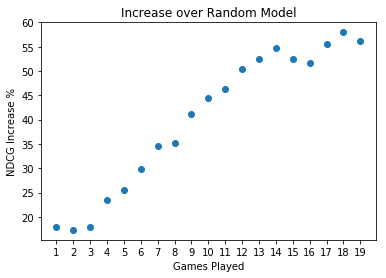

In [32]:
user_increases = user_increase1 + user_increase2
# user_abs
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), user_increases)
ax.set_xticks(list(range(1,20)))
ax.set_title('Increase over Random Model')
ax.set_xlabel('Games Played')
ax.set_ylabel('NDCG Increase %')
fig.show()
# fig.savefig('../figures/increase_games_played.png')

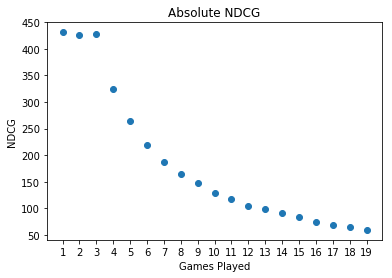

In [34]:
user_results = user_results1 + user_results2
absolute_increase = np.array(user_results)[:,0]
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), absolute_increase)
ax.set_xticks(list(range(1,20)))
ax.set_title('Absolute NDCG')
ax.set_xlabel('Games Played')
ax.set_ylabel('NDCG')
fig.show()
# fig.savefig('../figures/absolute_games_played.png')

## Cold Start for Items

In [14]:
min_user_counts_datasets1 = [create_dataset(train_val, min_games_played=1, min_users_for_game=i) for i in range(1,10)]

Number of users:  10192
first train test split size: 53282, 8503 
Number of users:  10177
first train test split size: 51985, 8811 
Number of users:  10158
first train test split size: 50415, 9472 
Number of users:  10139
first train test split size: 50348, 8755 
Number of users:  10115
first train test split size: 48980, 9268 
Number of users:  10107
first train test split size: 48960, 8686 
Number of users:  10085
first train test split size: 48168, 8773 
Number of users:  10063
first train test split size: 48172, 8069 
Number of users:  10050
first train test split size: 47158, 8475 


In [15]:
# prediction vs random_prediction ndcg
item_results1 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_user_counts_datasets1]
item_increase1 = [((predicted / random) - 1) * 100 for predicted, random in item_results1]

ndcg:  424.365635435
random_ndcg:  359.502063295
ndcg:  428.062593462
random_ndcg:  360.549766716
ndcg:  430.009713229
random_ndcg:  356.454271364
ndcg:  430.345438786
random_ndcg:  359.317685251
ndcg:  428.701882087
random_ndcg:  357.759042734
ndcg:  429.589627781
random_ndcg:  358.759038418
ndcg:  425.438680142
random_ndcg:  355.181564806
ndcg:  427.026674432
random_ndcg:  354.668013163
ndcg:  425.326833497
random_ndcg:  355.535222838


In [17]:
min_user_counts_datasets2 = [create_dataset(train_val, min_games_played=1, min_users_for_game=i) for i in range(10,20)]

Number of users:  10034
first train test split size: 46900, 8153 
Number of users:  10015
first train test split size: 45940, 8420 
Number of users:  10005
first train test split size: 45850, 7910 
Number of users:  9987
first train test split size: 45183, 7895 
Number of users:  9971
first train test split size: 44633, 7960 
Number of users:  9963
first train test split size: 44311, 7892 
Number of users:  9954
first train test split size: 44245, 7605 
Number of users:  9949
first train test split size: 43222, 8135 
Number of users:  9934
first train test split size: 42980, 8017 
Number of users:  9925
first train test split size: 43512, 7067 


In [18]:
# prediction vs random_prediction ndcg
item_results2 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_user_counts_datasets2]
item_increase2 = [((predicted / random) - 1) * 100 for predicted, random in item_results2]

ndcg:  424.746366028
random_ndcg:  354.600045045
ndcg:  423.683711599
random_ndcg:  351.488426606
ndcg:  423.298176092
random_ndcg:  354.896958054
ndcg:  423.153155444
random_ndcg:  349.306919002
ndcg:  423.386130051
random_ndcg:  350.275611414
ndcg:  420.159857847
random_ndcg:  350.152921428
ndcg:  420.405357366
random_ndcg:  352.114883362
ndcg:  420.793073089
random_ndcg:  349.278120918
ndcg:  421.669817998
random_ndcg:  347.915982017
ndcg:  419.979141982
random_ndcg:  348.67410197


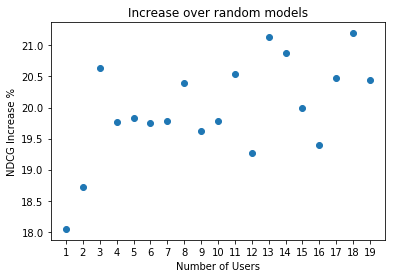

In [25]:
item_increases = item_increase1 + item_increase2
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), item_increases)
ax.set_title('Increase over random models')
ax.set_xlabel('Number of Users')
ax.set_ylabel('NDCG Increase %')
ax.set_xticks(list(range(1,20)))
fig.show()
fig.savefig('../figures/increase_users_for_items.png')

## 5 Games Played+ As Baseline

In [22]:
optimal_games_n_users_datasets = [create_dataset(train_val, min_games_played=5, min_users_for_game=i) for i in range(1,20)]

Number of users:  2199
first train test split size: 43706, 6720 
Number of users:  2198
first train test split size: 42512, 6994 
Number of users:  2198
first train test split size: 41763, 6865 
Number of users:  2198
first train test split size: 41142, 6743 
Number of users:  2198
first train test split size: 40482, 6608 
Number of users:  2198
first train test split size: 39991, 6528 
Number of users:  2198
first train test split size: 39433, 6446 
Number of users:  2198
first train test split size: 38893, 6347 
Number of users:  2198
first train test split size: 38406, 6261 
Number of users:  2198
first train test split size: 37939, 6185 
Number of users:  2198
first train test split size: 37408, 6082 
Number of users:  2198
first train test split size: 36921, 6002 
Number of users:  2198
first train test split size: 36386, 5908 
Number of users:  2198
first train test split size: 35998, 5843 
Number of users:  2197
first train test split size: 35620, 5897 
Number of users:  2196
fi

In [23]:
results_optimal_games_n_users = [get_ndcg_and_random_ndcg(dataset) for dataset in optimal_games_n_users_datasets]
optimal_games_item_increase = [((predicted / random) - 1) * 100 for predicted, random in results_optimal_games_n_users]

ndcg:  264.516087887
random_ndcg:  208.011943613
ndcg:  269.762861809
random_ndcg:  208.97919148
ndcg:  273.107463907
random_ndcg:  209.835322161
ndcg:  273.617186165
random_ndcg:  209.285715376
ndcg:  276.940748499
random_ndcg:  212.541227677
ndcg:  279.111205521
random_ndcg:  214.215815606
ndcg:  279.948323427
random_ndcg:  213.27856396
ndcg:  280.754779383
random_ndcg:  213.190169748
ndcg:  281.660680602
random_ndcg:  216.90452359
ndcg:  283.539577328
random_ndcg:  216.337465577
ndcg:  284.364401041
random_ndcg:  217.597094961
ndcg:  282.56483939
random_ndcg:  218.459782742
ndcg:  282.599872221
random_ndcg:  220.153996636
ndcg:  284.496373296
random_ndcg:  221.963798117
ndcg:  285.567029903
random_ndcg:  220.628504139
ndcg:  282.740969176
random_ndcg:  220.85718535
ndcg:  284.772344336
random_ndcg:  221.914168751
ndcg:  286.581516329
random_ndcg:  224.057556309
ndcg:  288.275414858
random_ndcg:  224.990878356


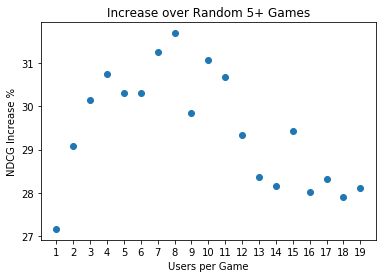

In [27]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), optimal_games_item_increase)
ax.set_title('Increase over Random 5+ Games')
ax.set_xlabel('Users per Game')
ax.set_ylabel('NDCG Increase %')
ax.set_xticks(list(range(1,20)))
fig.show()
# fig.savefig('../figures/increase_users_for_items_at_5.png')

## Final Model

In [28]:
final_model_dataset = create_dataset(train_val, min_games_played=5, min_users_for_game=3)
k_fold_prediction_rdds = fit_and_predict_kfold(als_model, final_model_dataset)
ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
random_ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='random_prediction') for predictions_rdd in k_fold_prediction_rdds]
ndcg = sum(ndcgs) / len(ndcgs)
random_ndcg = sum(random_ndcgs) / len(random_ndcgs)
final_model_results = (ndcg, random_ndcg)
final_model_results

Number of users:  2198
first train test split size: 41763, 6865 


(273.10746390662069, 209.83532216054897)

In [29]:
final_increase = ((final_model_results[0] / final_model_results[1]) - 1) * 100
print('Final Model Validation Increase: {}%'.format(round(final_increase, 3)))

Final Model Increase: 30.153%


#### Test on Holdout Validation

In [49]:
final_model_training = EDA.restrict_user_item(train_val, min_games_played=5, min_users_for_game=3)
final_model_holdout = EDA.restrict_user_item(holdout_test, min_games_played=5, min_users_for_game=3)
final_splitter = Split.PandasTrainTest(final_model_holdout)
holdout_train_games, holdout_test_games  = final_splitter.user_games_split(final_model_holdout, game_split_train=.3)
final_model_training = final_model_training.append(holdout_train_games)

In [54]:
final_model_training_spark_dataset = spark_session.createDataFrame(final_model_training)
holdout_test_spark_dataset = spark_session.createDataFrame(holdout_test_games)
training_fitted_model = als_model.fit(final_model_training_spark_dataset)
final_test_predictions = training_fitted_model.transform(holdout_test_spark_dataset)
final_test_predictions_rdd = final_test_predictions.rdd
# How valuable is this kind of validation here?
# How would we implement it?
final_test_ndcg = get_rdd_ndcg(final_test_predictions_rdd, top_n=5, prediction_col='prediction')
final_test_random_ndcg = get_rdd_ndcg(final_test_predictions_rdd, top_n=5, prediction_col='random_prediction')

In [55]:
final_test_increase = ((final_test_ndcg / final_test_random_ndcg) - 1) * 100
print('Final Model Validation Increase: {}%'.format(round(final_test_increase, 3)))

Final Model Validation Increase: 34.193%


In [57]:
evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_min_max") \
    .setPredictionCol("prediction")
rmse = evaluator.evaluate(final_test_predictions)
random_evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_min_max") \
    .setPredictionCol("random_prediction")
random_rmse = random_evaluator.evaluate(final_test_predictions)

In [63]:
final_test_rmse_increase = ((random_rmse / rmse) - 1) * 100
print('Final Model Random RMSE Increase: {}%'.format(round(final_test_rmse_increase, 3)))

Final Model Random RMSE Increase: 222.554%


## We could look at absolute NDCG increases / decreases.. 
But the size of the dataset will change the outcome vs ideal,  
As well as the absolute DCG (less data, lower gain)

In [32]:
raw_increase_ndcg = np.array(results_optimal_games_n_users)[:,0]

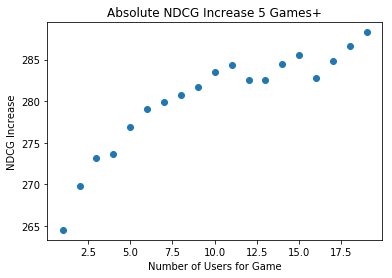

In [35]:
### Even without dividing by data size, absolute NDCG will increase 
### as number of games decreases - Because we are recommending games to users
### and removing possibilities to get wrong
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), raw_increase_ndcg)
ax.set_title('Absolute NDCG Increase 5 Games+')
ax.set_xlabel('Number of Users for Game')
ax.set_ylabel('NDCG Increase')
fig.show()
fig.savefig('../figures/absolute_optimal_games_n_users_increases.png')

In [37]:
user_results = user_results1 + user_results2
absolute_increase = np.array(user_results)[:,0]
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), absolute_increase)
ax.set_xticks(list(range(1,20)))
ax.set_title('Absolute NDCG')
ax.set_xlabel('Games Played')
ax.set_ylabel('NDCG')
fig.show()
# fig.savefig('../figures/absolute_games_played.png')